# ü§ñ Trabajo Final - Modelos de Machine Learning
## Parte 3: Random Forest, XGBoost y Redes Neuronales

**Maestr√≠a en Econom√≠a Aplicada - UBA**  
**Dataset:** Inmuebles filtrado y optimizado

---


## üìö Librer√≠as e Importaciones

In [1]:
# Librer√≠as b√°sicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from tqdm import tqdm
import time
import warnings
warnings.filterwarnings('ignore')

# Configuraci√≥n de visualizaci√≥n
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("‚úÖ Librer√≠as cargadas correctamente")


‚úÖ Librer√≠as cargadas correctamente


## üìä Carga y Preparaci√≥n de Datos


In [3]:
# Cargar dataset filtrado y optimizado desde notebook 01
df = pd.read_csv('train_bi_2025_filtered.csv')
print("‚úÖ Dataset filtrado y optimizado cargado")
print(f"üìä Dimensiones: {df.shape[0]:,} filas √ó {df.shape[1]} columnas")

def prepare_data_for_modeling(df, include_description=False):
    """
    Prepara los datos para modelado ML.
    El dataset ya viene optimizado de la notebook 01.
    """
    df_model = df.copy()
    
    # Variables a excluir siempre
    exclude_vars = ['price', 'lat', 'lon']
    
    # Opcionalmente excluir description
    if not include_description and 'description' in df_model.columns:
        exclude_vars.append('description')
    
    # Variables predictoras
    X_raw = df_model.drop(columns=exclude_vars, errors='ignore')
    y = df_model['price']
    
    # üîß CONVERSI√ìN DE VARIABLES CATEG√ìRICAS A NUM√âRICAS
    print("üîß Procesando variables categ√≥ricas...")
    
    # Identificar variables categ√≥ricas (object/string)
    categorical_vars = X_raw.select_dtypes(include=['object']).columns.tolist()
    numerical_vars = X_raw.select_dtypes(exclude=['object']).columns.tolist()
    
    print(f"   üìù Variables categ√≥ricas: {len(categorical_vars)}")
    print(f"   üî¢ Variables num√©ricas: {len(numerical_vars)}")
    
    # Convertir variables categ√≥ricas usando get_dummies
    if len(categorical_vars) > 0:
        X_categorical = pd.get_dummies(X_raw[categorical_vars], drop_first=True)
        X_numerical = X_raw[numerical_vars]
        X = pd.concat([X_numerical, X_categorical], axis=1)
        print(f"   ‚úÖ Variables categ√≥ricas convertidas a {X_categorical.shape[1]} dummies")
    else:
        X = X_raw
    
    print(f"üéØ Variables predictoras finales: {X.shape[1]}")
    print(f"üìà Variable objetivo: {y.name} (media: ${y.mean():,.0f})")
    
    return X, y

# Preparar datos
X, y = prepare_data_for_modeling(df)

# Divisi√≥n train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=None
)

print(f"\nüìä DIVISI√ìN DE DATOS:")
print("=" * 30)
print(f"Entrenamiento: {X_train.shape[0]:,} muestras")
print(f"Prueba:        {X_test.shape[0]:,} muestras")
print(f"Features:      {X_train.shape[1]} variables")

# Estandarizaci√≥n para modelos que la requieren (ahora solo variables num√©ricas)
print(f"\nüîß Estandarizaci√≥n de datos...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"‚úÖ Datos estandarizados:")
print(f"   X_train_scaled: {X_train_scaled.shape}")
print(f"   X_test_scaled: {X_test_scaled.shape}")
print(f"   Preparados para modelos que requieren normalizaci√≥n")

‚úÖ Dataset filtrado y optimizado cargado
üìä Dimensiones: 311,660 filas √ó 15 columnas
üîß Procesando variables categ√≥ricas...
   üìù Variables categ√≥ricas: 3
   üî¢ Variables num√©ricas: 8
   ‚úÖ Variables categ√≥ricas convertidas a 85 dummies
üéØ Variables predictoras finales: 93
üìà Variable objetivo: price (media: $160,807)

üìä DIVISI√ìN DE DATOS:
Entrenamiento: 249,328 muestras
Prueba:        62,332 muestras
Features:      93 variables

üîß Estandarizaci√≥n de datos...
‚úÖ Datos estandarizados:
   X_train_scaled: (249328, 93)
   X_test_scaled: (62332, 93)
   Preparados para modelos que requieren normalizaci√≥n


## üå≤ Random Forest Regressor

In [4]:
# Random Forest con b√∫squeda de hiperpar√°metros
print("üå≤ RANDOM FOREST")
print("=" * 25)

# Estrategia 2-fases: optimizar en muestra, evaluar en dataset completo
sample_size = min(25000, len(X_train))  # M√°ximo 25K para velocidad
indices = np.random.choice(len(X_train), sample_size, replace=False)
X_sample = X_train.iloc[indices]
y_sample = y_train.iloc[indices]

print(f"üîç Muestra para optimizaci√≥n: {sample_size:,} observaciones")

# Grid simplificado pero efectivo
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 15, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

total_combinations = np.prod([len(v) for v in param_grid_rf.values()])
print(f"üéØ Grid completo: {total_combinations} combinaciones")

# RandomizedSearchCV con verbose para ver progreso
rf_search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid_rf,
    n_iter=8,  # Solo 8 combinaciones para velocidad
    cv=2,      # 2-fold CV para velocidad
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1,
    verbose=2  # üî• AQU√ç est√° el progreso real!
)

print(f"‚ö° Probando {rf_search.n_iter} combinaciones con CV={rf_search.cv}")
print("‚è≥ Buscando mejores hiperpar√°metros...")

start_time = time.time()
rf_search.fit(X_sample, y_sample)
search_time = time.time() - start_time

print(f"‚úÖ B√∫squeda completada en {search_time:.1f} segundos")
print(f"üèÜ Mejores par√°metros: {rf_search.best_params_}")

# Modelo final con mejores par√°metros en dataset completo
print("\nüîÑ Entrenando modelo final en dataset completo...")
rf_final = RandomForestRegressor(**rf_search.best_params_, random_state=42, n_jobs=-1)

with tqdm(total=3, desc="Random Forest Final") as pbar:
    pbar.set_description("Entrenando...")
    rf_final.fit(X_train, y_train)
    pbar.update(1)
    
    pbar.set_description("Predicciones train...")
    y_pred_train_rf = rf_final.predict(X_train)
    pbar.update(1)
    
    pbar.set_description("Predicciones test...")
    y_pred_test_rf = rf_final.predict(X_test)
    pbar.update(1)

# M√©tricas
train_rmse_rf = np.sqrt(mean_squared_error(y_train, y_pred_train_rf))
test_rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_test_rf))
train_mae_rf = mean_absolute_error(y_train, y_pred_train_rf)
test_mae_rf = mean_absolute_error(y_test, y_pred_test_rf)
train_r2_rf = r2_score(y_train, y_pred_train_rf)
test_r2_rf = r2_score(y_test, y_pred_test_rf)

print(f"\nüìä RESULTADOS RANDOM FOREST:")
print("=" * 40)
print(f"RMSE Entrenamiento: ${train_rmse_rf:,.0f}")
print(f"RMSE Prueba:        ${test_rmse_rf:,.0f}")
print(f"MAE Entrenamiento:  ${train_mae_rf:,.0f}")
print(f"MAE Prueba:         ${test_mae_rf:,.0f}")
print(f"R¬≤ Entrenamiento:   {train_r2_rf:.4f}")
print(f"R¬≤ Prueba:          {test_r2_rf:.4f}")
print(f"Overfitting Ratio:  {test_rmse_rf/train_rmse_rf:.3f}")


üå≤ RANDOM FOREST
üîç Muestra para optimizaci√≥n: 25,000 observaciones
üéØ Grid completo: 48 combinaciones
‚ö° Probando 8 combinaciones con CV=2
‚è≥ Buscando mejores hiperpar√°metros...
Fitting 2 folds for each of 8 candidates, totalling 16 fits
‚úÖ B√∫squeda completada en 9.6 segundos
üèÜ Mejores par√°metros: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None}

üîÑ Entrenando modelo final en dataset completo...


Predicciones test...: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 3/3 [00:46<00:00, 15.60s/it] 


üìä RESULTADOS RANDOM FOREST:
RMSE Entrenamiento: $21,499
RMSE Prueba:        $33,518
MAE Entrenamiento:  $14,457
MAE Prueba:         $22,491
R¬≤ Entrenamiento:   0.9333
R¬≤ Prueba:          0.8347
Overfitting Ratio:  1.559


## üöÄ XGBoost Regressor

In [5]:
# XGBoost con b√∫squeda de hiperpar√°metros
print("üöÄ XGBOOST")
print("=" * 15)

# Usar la misma muestra para optimizaci√≥n
print(f"üîç Muestra para optimizaci√≥n: {sample_size:,} observaciones")

# Grid de hiperpar√°metros para XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

total_combinations_xgb = np.prod([len(v) for v in param_grid_xgb.values()])
print(f"üéØ Grid completo: {total_combinations_xgb} combinaciones")

# RandomizedSearchCV para XGBoost
xgb_search = RandomizedSearchCV(
    XGBRegressor(random_state=42, n_jobs=-1, eval_metric='rmse'),
    param_grid_xgb,
    n_iter=8,  # 8 combinaciones para velocidad
    cv=2,      # 2-fold CV
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1,
    verbose=2
)

print(f"‚ö° Probando {xgb_search.n_iter} combinaciones con CV={xgb_search.cv}")
print("‚è≥ Buscando mejores hiperpar√°metros...")

start_time = time.time()
xgb_search.fit(X_sample, y_sample)
search_time = time.time() - start_time

print(f"‚úÖ B√∫squeda completada en {search_time:.1f} segundos")
print(f"üèÜ Mejores par√°metros: {xgb_search.best_params_}")

# Modelo final con mejores par√°metros
print("\nüîÑ Entrenando modelo XGBoost final...")
xgb_final = XGBRegressor(**xgb_search.best_params_, random_state=42, n_jobs=-1, eval_metric='rmse')

with tqdm(total=3, desc="XGBoost Final") as pbar:
    pbar.set_description("Entrenando...")
    xgb_final.fit(X_train, y_train)
    pbar.update(1)
    
    pbar.set_description("Predicciones train...")
    y_pred_train_xgb = xgb_final.predict(X_train)
    pbar.update(1)
    
    pbar.set_description("Predicciones test...")
    y_pred_test_xgb = xgb_final.predict(X_test)
    pbar.update(1)

# M√©tricas
train_rmse_xgb = np.sqrt(mean_squared_error(y_train, y_pred_train_xgb))
test_rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_test_xgb))
train_mae_xgb = mean_absolute_error(y_train, y_pred_train_xgb)
test_mae_xgb = mean_absolute_error(y_test, y_pred_test_xgb)
train_r2_xgb = r2_score(y_train, y_pred_train_xgb)
test_r2_xgb = r2_score(y_test, y_pred_test_xgb)

print(f"\nüìä RESULTADOS XGBOOST:")
print("=" * 30)
print(f"RMSE Entrenamiento: ${train_rmse_xgb:,.0f}")
print(f"RMSE Prueba:        ${test_rmse_xgb:,.0f}")
print(f"MAE Entrenamiento:  ${train_mae_xgb:,.0f}")
print(f"MAE Prueba:         ${test_mae_xgb:,.0f}")
print(f"R¬≤ Entrenamiento:   {train_r2_xgb:.4f}")
print(f"R¬≤ Prueba:          {test_r2_xgb:.4f}")
print(f"Overfitting Ratio:  {test_rmse_xgb/train_rmse_xgb:.3f}")


üöÄ XGBOOST
üîç Muestra para optimizaci√≥n: 25,000 observaciones
üéØ Grid completo: 72 combinaciones
‚ö° Probando 8 combinaciones con CV=2
‚è≥ Buscando mejores hiperpar√°metros...
Fitting 2 folds for each of 8 candidates, totalling 16 fits
‚úÖ B√∫squeda completada en 4.1 segundos
üèÜ Mejores par√°metros: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.8}

üîÑ Entrenando modelo XGBoost final...


Predicciones test...: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 3/3 [00:02<00:00,  1.28it/s] 


üìä RESULTADOS XGBOOST:
RMSE Entrenamiento: $36,032
RMSE Prueba:        $36,452
MAE Entrenamiento:  $25,198
MAE Prueba:         $25,436
R¬≤ Entrenamiento:   0.8126
R¬≤ Prueba:          0.8045
Overfitting Ratio:  1.012


## üß† Red Neuronal (MLP)

In [6]:
# Red Neuronal (MLP) con datos estandarizados
print("üß† RED NEURONAL (MLP)")
print("=" * 25)

# Las redes neuronales necesitan datos estandarizados
print(f"üîç Muestra para optimizaci√≥n: {sample_size:,} observaciones (datos estandarizados)")

# Crear muestra estandarizada para optimizaci√≥n
X_sample_scaled = scaler.transform(X_sample)
y_sample_scaled = y_sample.copy()

# Grid de hiperpar√°metros para MLP
param_grid_mlp = {
    'hidden_layer_sizes': [(50,), (100,), (50, 25), (100, 50)],
    'alpha': [0.001, 0.01, 0.1],
    'learning_rate_init': [0.001, 0.01],
    'max_iter': [200, 500]
}

total_combinations_mlp = np.prod([len(v) for v in param_grid_mlp.values()])
print(f"üéØ Grid completo: {total_combinations_mlp} combinaciones")

# RandomizedSearchCV para MLP
mlp_search = RandomizedSearchCV(
    MLPRegressor(random_state=42, early_stopping=True),
    param_grid_mlp,
    n_iter=8,  # 8 combinaciones
    cv=2,      # 2-fold CV
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1,
    verbose=2
)

print(f"‚ö° Probando {mlp_search.n_iter} combinaciones con CV={mlp_search.cv}")
print("‚è≥ Buscando mejores hiperpar√°metros...")

start_time = time.time()
mlp_search.fit(X_sample_scaled, y_sample_scaled)
search_time = time.time() - start_time

print(f"‚úÖ B√∫squeda completada en {search_time:.1f} segundos")
print(f"üèÜ Mejores par√°metros: {mlp_search.best_params_}")

# Modelo final con mejores par√°metros
print("\nüîÑ Entrenando modelo MLP final...")
mlp_final = MLPRegressor(**mlp_search.best_params_, random_state=42, early_stopping=True)

with tqdm(total=3, desc="MLP Final") as pbar:
    pbar.set_description("Entrenando...")
    mlp_final.fit(X_train_scaled, y_train)
    pbar.update(1)
    
    pbar.set_description("Predicciones train...")
    y_pred_train_mlp = mlp_final.predict(X_train_scaled)
    pbar.update(1)
    
    pbar.set_description("Predicciones test...")
    y_pred_test_mlp = mlp_final.predict(X_test_scaled)
    pbar.update(1)

# M√©tricas
train_rmse_mlp = np.sqrt(mean_squared_error(y_train, y_pred_train_mlp))
test_rmse_mlp = np.sqrt(mean_squared_error(y_test, y_pred_test_mlp))
train_mae_mlp = mean_absolute_error(y_train, y_pred_train_mlp)
test_mae_mlp = mean_absolute_error(y_test, y_pred_test_mlp)
train_r2_mlp = r2_score(y_train, y_pred_train_mlp)
test_r2_mlp = r2_score(y_test, y_pred_test_mlp)

print(f"\nüìä RESULTADOS RED NEURONAL:")
print("=" * 35)
print(f"RMSE Entrenamiento: ${train_rmse_mlp:,.0f}")
print(f"RMSE Prueba:        ${test_rmse_mlp:,.0f}")
print(f"MAE Entrenamiento:  ${train_mae_mlp:,.0f}")
print(f"MAE Prueba:         ${test_mae_mlp:,.0f}")
print(f"R¬≤ Entrenamiento:   {train_r2_mlp:.4f}")
print(f"R¬≤ Prueba:          {test_r2_mlp:.4f}")
print(f"Overfitting Ratio:  {test_rmse_mlp/train_rmse_mlp:.3f}")
print(f"Iteraciones:        {mlp_final.n_iter_}")


üß† RED NEURONAL (MLP)
üîç Muestra para optimizaci√≥n: 25,000 observaciones (datos estandarizados)
üéØ Grid completo: 48 combinaciones
‚ö° Probando 8 combinaciones con CV=2
‚è≥ Buscando mejores hiperpar√°metros...
Fitting 2 folds for each of 8 candidates, totalling 16 fits
‚úÖ B√∫squeda completada en 30.4 segundos
üèÜ Mejores par√°metros: {'max_iter': 500, 'learning_rate_init': 0.01, 'hidden_layer_sizes': (50, 25), 'alpha': 0.01}

üîÑ Entrenando modelo MLP final...


Predicciones test...: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 3/3 [02:24<00:00, 48.21s/it]  


üìä RESULTADOS RED NEURONAL:
RMSE Entrenamiento: $37,193
RMSE Prueba:        $37,258
MAE Entrenamiento:  $25,871
MAE Prueba:         $25,962
R¬≤ Entrenamiento:   0.8003
R¬≤ Prueba:          0.7958
Overfitting Ratio:  1.002
Iteraciones:        144


## üìä Comparaci√≥n Final de Modelos

In [7]:
# Comparaci√≥n final de todos los modelos
print("üèÜ COMPARACI√ìN FINAL DE MODELOS")
print("=" * 50)

# Crear tabla comparativa
results_df = pd.DataFrame({
    'Modelo': ['Random Forest', 'XGBoost', 'Red Neuronal (MLP)'],
    'RMSE_Test': [test_rmse_rf, test_rmse_xgb, test_rmse_mlp],
    'MAE_Test': [test_mae_rf, test_mae_xgb, test_mae_mlp],
    'R2_Test': [test_r2_rf, test_r2_xgb, test_r2_mlp],
    'RMSE_Train': [train_rmse_rf, train_rmse_xgb, train_rmse_mlp],
    'R2_Train': [train_r2_rf, train_r2_xgb, train_r2_mlp],
    'Overfitting_Ratio': [test_rmse_rf/train_rmse_rf, test_rmse_xgb/train_rmse_xgb, test_rmse_mlp/train_rmse_mlp]
})

# Formatear tabla para mejor visualizaci√≥n
results_display = results_df.copy()
results_display['RMSE_Test'] = results_display['RMSE_Test'].apply(lambda x: f"${x:,.0f}")
results_display['MAE_Test'] = results_display['MAE_Test'].apply(lambda x: f"${x:,.0f}")
results_display['R2_Test'] = results_display['R2_Test'].apply(lambda x: f"{x:.4f}")
results_display['RMSE_Train'] = results_display['RMSE_Train'].apply(lambda x: f"${x:,.0f}")
results_display['R2_Train'] = results_display['R2_Train'].apply(lambda x: f"{x:.4f}")
results_display['Overfitting_Ratio'] = results_display['Overfitting_Ratio'].apply(lambda x: f"{x:.3f}")

print(results_display.to_string(index=False))

# Identificar el mejor modelo
best_model_idx = results_df['RMSE_Test'].idxmin()
best_model = results_df.loc[best_model_idx, 'Modelo']
best_rmse = results_df.loc[best_model_idx, 'RMSE_Test']

print(f"\nü•á MEJOR MODELO: {best_model}")
print(f"   RMSE Test: ${best_rmse:,.0f}")
print(f"   R¬≤ Test: {results_df.loc[best_model_idx, 'R2_Test']:.4f}")

# Diferencias con el peor modelo
worst_model_idx = results_df['RMSE_Test'].idxmax()
worst_rmse = results_df.loc[worst_model_idx, 'RMSE_Test']
improvement = ((worst_rmse - best_rmse) / worst_rmse) * 100

print(f"\nüìà Mejora vs peor modelo: {improvement:.1f}% menos error")


üèÜ COMPARACI√ìN FINAL DE MODELOS
            Modelo RMSE_Test MAE_Test R2_Test RMSE_Train R2_Train Overfitting_Ratio
     Random Forest   $33,518  $22,491  0.8347    $21,499   0.9333             1.559
           XGBoost   $36,452  $25,436  0.8045    $36,032   0.8126             1.012
Red Neuronal (MLP)   $37,258  $25,962  0.7958    $37,193   0.8003             1.002

ü•á MEJOR MODELO: Random Forest
   RMSE Test: $33,518
   R¬≤ Test: 0.8347

üìà Mejora vs peor modelo: 10.0% menos error


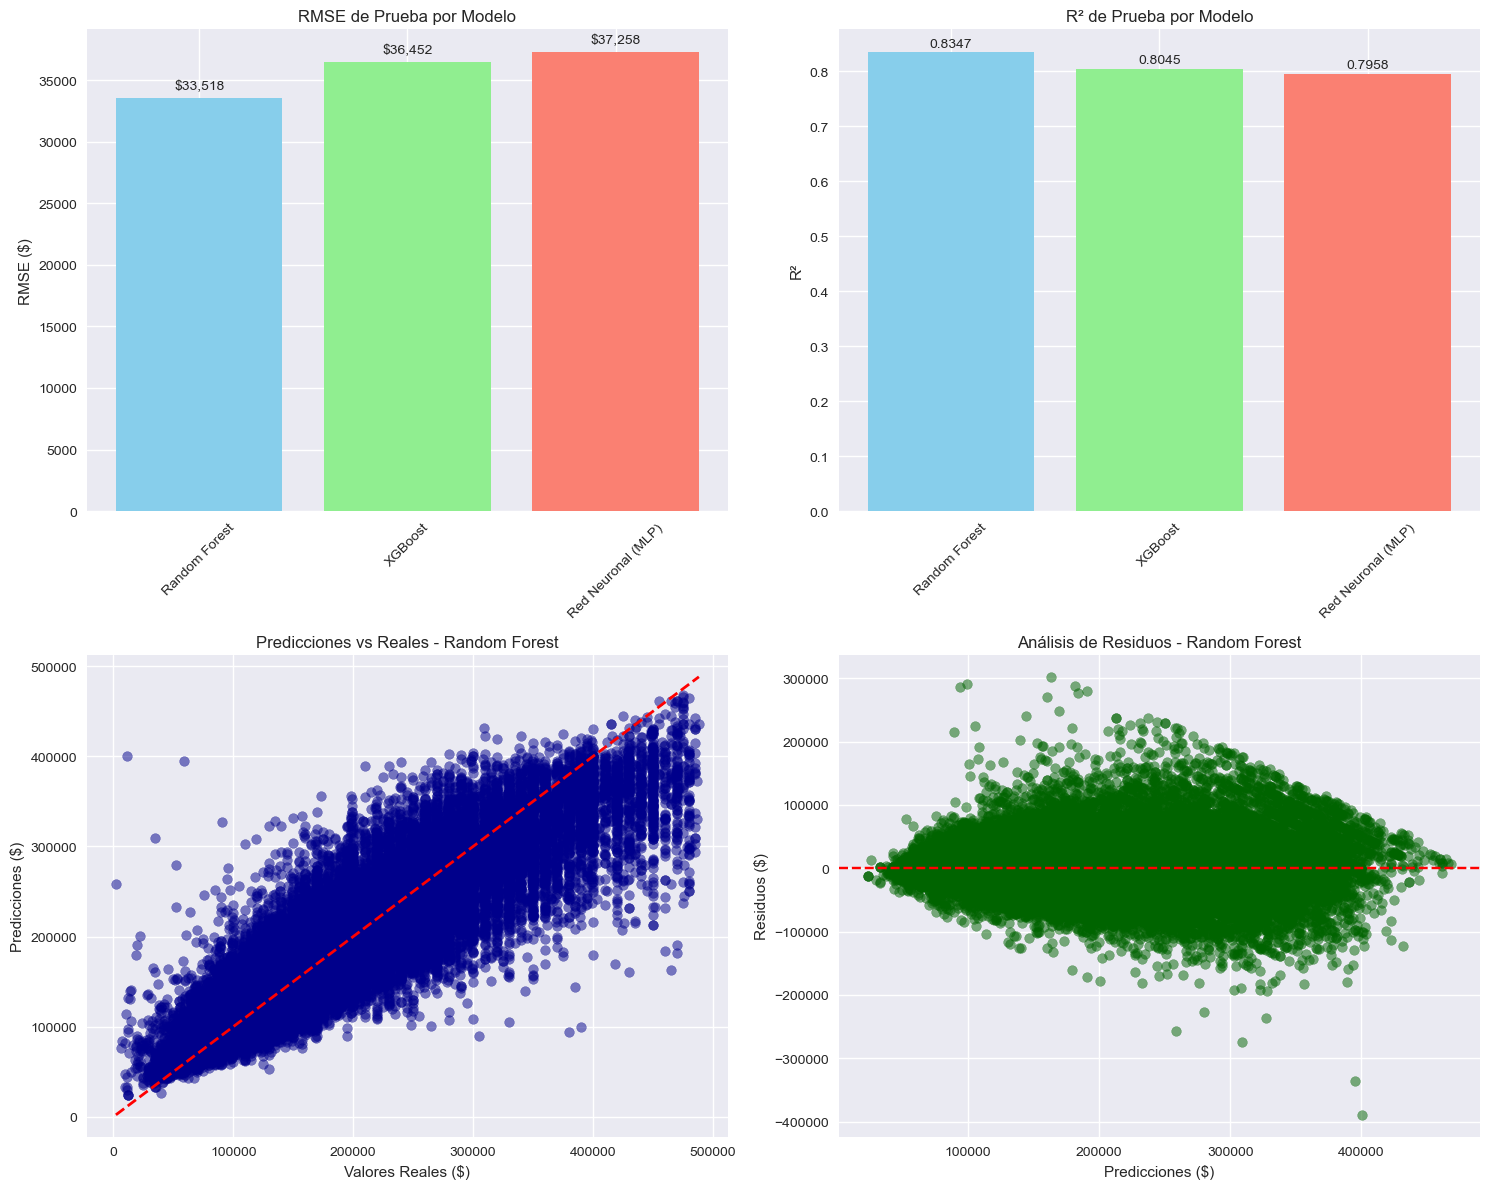


üìä AN√ÅLISIS DE RESIDUOS - Random Forest:
Media de residuos:     $-766
Desv. est√°ndar:       $33,510
Residuo m√≠nimo:       $-389,105
Residuo m√°ximo:       $302,113
Mediana de residuos:  $-2,310


In [8]:
# Visualizaciones comparativas
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Comparaci√≥n de RMSE
models = results_df['Modelo']
rmse_values = results_df['RMSE_Test']
bars = axes[0,0].bar(models, rmse_values, color=['skyblue', 'lightgreen', 'salmon'])
axes[0,0].set_title('RMSE de Prueba por Modelo')
axes[0,0].set_ylabel('RMSE ($)')
axes[0,0].tick_params(axis='x', rotation=45)
for bar, value in zip(bars, rmse_values):
    axes[0,0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 500, 
                   f'${value:,.0f}', ha='center', va='bottom')

# 2. Comparaci√≥n de R¬≤
r2_values = results_df['R2_Test']
bars = axes[0,1].bar(models, r2_values, color=['skyblue', 'lightgreen', 'salmon'])
axes[0,1].set_title('R¬≤ de Prueba por Modelo')
axes[0,1].set_ylabel('R¬≤')
axes[0,1].tick_params(axis='x', rotation=45)
for bar, value in zip(bars, r2_values):
    axes[0,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
                   f'{value:.4f}', ha='center', va='bottom')

# 3. Predicciones vs Valores Reales (mejor modelo)
if best_model == 'Random Forest':
    y_pred_best = y_pred_test_rf
elif best_model == 'XGBoost':
    y_pred_best = y_pred_test_xgb
else:
    y_pred_best = y_pred_test_mlp

axes[1,0].scatter(y_test, y_pred_best, alpha=0.5, color='darkblue')
axes[1,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1,0].set_xlabel('Valores Reales ($)')
axes[1,0].set_ylabel('Predicciones ($)')
axes[1,0].set_title(f'Predicciones vs Reales - {best_model}')

# 4. Residuos del mejor modelo
residuos = y_test - y_pred_best
axes[1,1].scatter(y_pred_best, residuos, alpha=0.5, color='darkgreen')
axes[1,1].axhline(y=0, color='r', linestyle='--')
axes[1,1].set_xlabel('Predicciones ($)')
axes[1,1].set_ylabel('Residuos ($)')
axes[1,1].set_title(f'An√°lisis de Residuos - {best_model}')

plt.tight_layout()
plt.show()

# Estad√≠sticas adicionales de residuos
print(f"\nüìä AN√ÅLISIS DE RESIDUOS - {best_model}:")
print("=" * 50)
print(f"Media de residuos:     ${residuos.mean():,.0f}")
print(f"Desv. est√°ndar:       ${residuos.std():,.0f}")
print(f"Residuo m√≠nimo:       ${residuos.min():,.0f}")
print(f"Residuo m√°ximo:       ${residuos.max():,.0f}")
print(f"Mediana de residuos:  ${residuos.median():,.0f}")


## üîç An√°lisis de Importancia de Variables


üîç IMPORTANCIA DE VARIABLES
üèÜ TOP 15 VARIABLES M√ÅS IMPORTANTES:
 1. surface_total             | RF: 0.2723 | XGB: 0.0411 | Prom: 0.1567
 2. surface_covered           | RF: 0.2390 | XGB: 0.0481 | Prom: 0.1436
 3. bathrooms                 | RF: 0.1218 | XGB: 0.0208 | Prom: 0.0713
 4. l3_Puerto Madero          | RF: 0.0263 | XGB: 0.1013 | Prom: 0.0638
 5. l3_Palermo                | RF: 0.0335 | XGB: 0.0859 | Prom: 0.0597
 6. rooms                     | RF: 0.0932 | XGB: 0.0114 | Prom: 0.0523
 7. l3_Belgrano               | RF: 0.0170 | XGB: 0.0672 | Prom: 0.0421
 8. l3_Recoleta               | RF: 0.0144 | XGB: 0.0548 | Prom: 0.0346
 9. l3_Balvanera              | RF: 0.0079 | XGB: 0.0365 | Prom: 0.0222
10. l3_Barrio Norte           | RF: 0.0054 | XGB: 0.0377 | Prom: 0.0215
11. l3_Nu√±ez                  | RF: 0.0052 | XGB: 0.0331 | Prom: 0.0191
12. created_year              | RF: 0.0318 | XGB: 0.0059 | Prom: 0.0189
13. l3_Villa Lugano           | RF: 0.0037 | XGB: 0.0284 | Prom: 

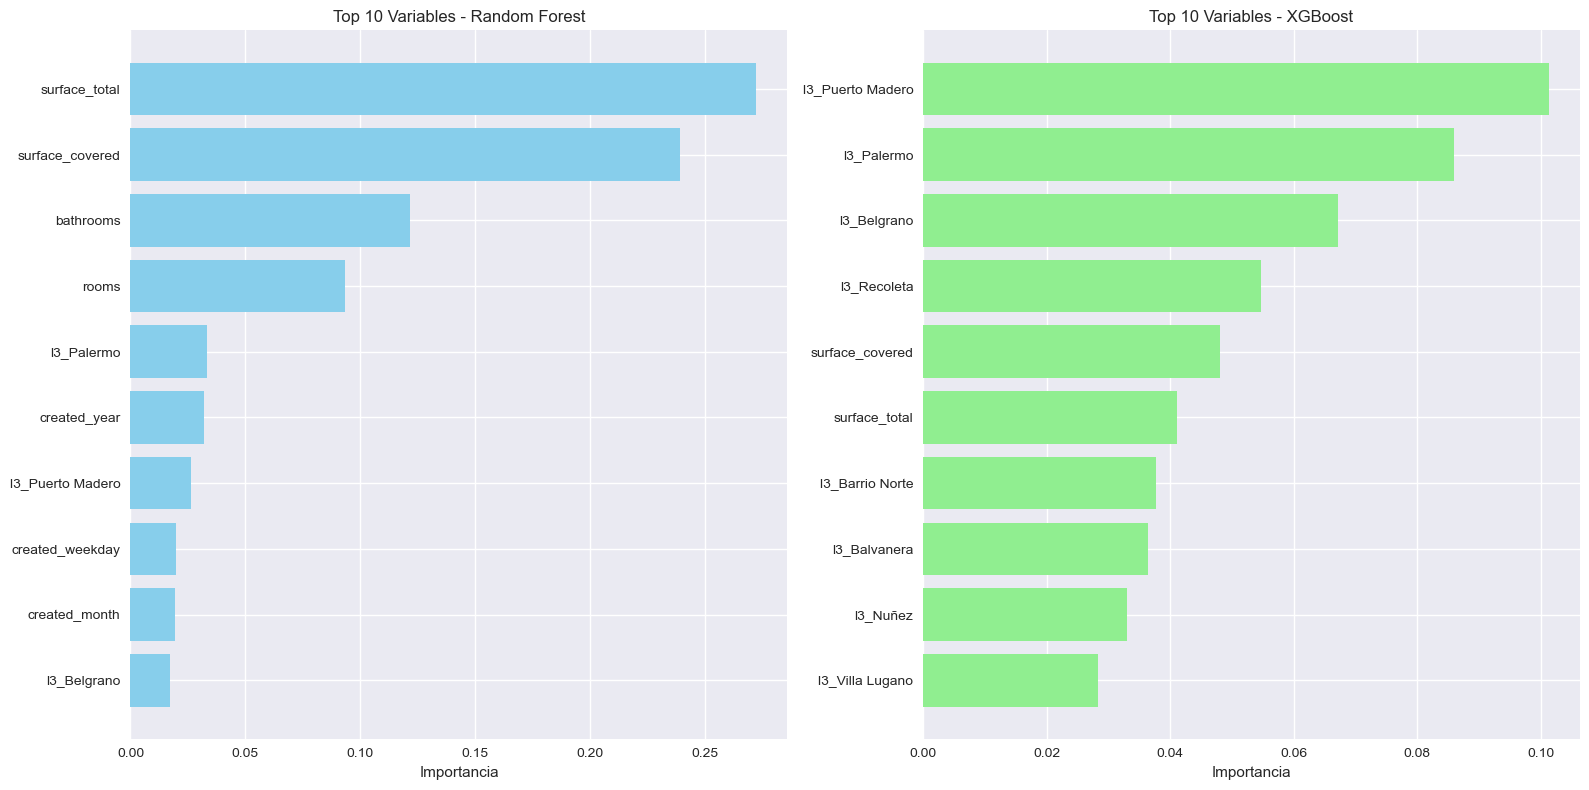


üìä AN√ÅLISIS POR CATEGOR√çAS:
Importancia por categor√≠a:
  Ubicaci√≥n Geogr√°fica     : 0.5073
  Caracter√≠sticas F√≠sicas  : 0.4238
  Variables Temporales     : 0.0441
  Otras                    : 0.0247

üìà DISTRIBUCI√ìN DE IMPORTANCIA:
Suma total importancia promedio: 1.0000
Top 5 variables explican:        49.5% del modelo
Top 10 variables explican:       66.8% del modelo
Top 15 variables explican:       74.7% del modelo


In [9]:
# An√°lisis de importancia de variables para modelos de ensamble
print("üîç IMPORTANCIA DE VARIABLES")
print("=" * 40)

# Obtener importancias de Random Forest y XGBoost
rf_importances = pd.DataFrame({
    'Variable': X.columns,
    'Importancia_RF': rf_final.feature_importances_
}).sort_values('Importancia_RF', ascending=False)

xgb_importances = pd.DataFrame({
    'Variable': X.columns,
    'Importancia_XGB': xgb_final.feature_importances_
}).sort_values('Importancia_XGB', ascending=False)

# Combinar importancias
feature_importance = rf_importances.merge(xgb_importances, on='Variable')
feature_importance['Importancia_Promedio'] = (feature_importance['Importancia_RF'] + 
                                             feature_importance['Importancia_XGB']) / 2
feature_importance = feature_importance.sort_values('Importancia_Promedio', ascending=False)

# Mostrar top 15 variables m√°s importantes
print("üèÜ TOP 15 VARIABLES M√ÅS IMPORTANTES:")
print("=" * 60)
top_features = feature_importance.head(15)
for i, (_, row) in enumerate(top_features.iterrows(), 1):
    print(f"{i:2d}. {row['Variable']:<25} | RF: {row['Importancia_RF']:.4f} | XGB: {row['Importancia_XGB']:.4f} | Prom: {row['Importancia_Promedio']:.4f}")

# Visualizaci√≥n de importancia
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Top 10 para Random Forest
top_rf = rf_importances.head(10)
axes[0].barh(range(len(top_rf)), top_rf['Importancia_RF'], color='skyblue')
axes[0].set_yticks(range(len(top_rf)))
axes[0].set_yticklabels(top_rf['Variable'])
axes[0].set_xlabel('Importancia')
axes[0].set_title('Top 10 Variables - Random Forest')
axes[0].invert_yaxis()

# Top 10 para XGBoost
top_xgb = xgb_importances.head(10)
axes[1].barh(range(len(top_xgb)), top_xgb['Importancia_XGB'], color='lightgreen')
axes[1].set_yticks(range(len(top_xgb)))
axes[1].set_yticklabels(top_xgb['Variable'])
axes[1].set_xlabel('Importancia')
axes[1].set_title('Top 10 Variables - XGBoost')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

# An√°lisis por categor√≠as
print(f"\nüìä AN√ÅLISIS POR CATEGOR√çAS:")
print("=" * 40)

def categorize_variable(var_name):
    if any(x in var_name.lower() for x in ['surface', 'room', 'bathroom']):
        return 'Caracter√≠sticas F√≠sicas'
    elif any(x in var_name.lower() for x in ['l3', 'l2', 'l1']):
        return 'Ubicaci√≥n Geogr√°fica'
    elif any(x in var_name.lower() for x in ['property_type']):
        return 'Tipo de Propiedad'
    elif any(x in var_name.lower() for x in ['created_year', 'created_month', 'created_quarter', 'created_weekday']):
        return 'Variables Temporales'
    else:
        return 'Otras'

feature_importance['Categoria'] = feature_importance['Variable'].apply(categorize_variable)
categoria_importance = feature_importance.groupby('Categoria')['Importancia_Promedio'].sum().sort_values(ascending=False)

print("Importancia por categor√≠a:")
for categoria, importancia in categoria_importance.items():
    print(f"  {categoria:<25}: {importancia:.4f}")

# Distribuci√≥n de importancia
print(f"\nüìà DISTRIBUCI√ìN DE IMPORTANCIA:")
print("=" * 40)
print(f"Suma total importancia promedio: {feature_importance['Importancia_Promedio'].sum():.4f}")
print(f"Top 5 variables explican:        {top_features.head(5)['Importancia_Promedio'].sum():.1%} del modelo")
print(f"Top 10 variables explican:       {top_features.head(10)['Importancia_Promedio'].sum():.1%} del modelo")
print(f"Top 15 variables explican:       {top_features.head(15)['Importancia_Promedio'].sum():.1%} del modelo")


## üìã Resumen y Conclusiones


In [10]:
# Resumen final del an√°lisis de modelos ML
print("üìã RESUMEN Y CONCLUSIONES - MODELOS DE MACHINE LEARNING")
print("=" * 70)

print(f"\nüéØ DATASET UTILIZADO:")
print(f"   ‚Ä¢ {X.shape[0]:,} observaciones")
print(f"   ‚Ä¢ {X.shape[1]} variables predictoras")
print(f"   ‚Ä¢ Dataset filtrado y optimizado (fechas convertidas en componentes temporales)")

print(f"\nü§ñ MODELOS EVALUADOS:")
print(f"   ‚Ä¢ Random Forest con b√∫squeda de hiperpar√°metros")
print(f"   ‚Ä¢ XGBoost con b√∫squeda de hiperpar√°metros") 
print(f"   ‚Ä¢ Red Neuronal (MLP) con estandarizaci√≥n")

print(f"\nüèÜ RESULTADOS FINALES:")
for i, (_, row) in enumerate(results_df.iterrows(), 1):
    print(f"   {i}. {row['Modelo']:<20} | RMSE: ${row['RMSE_Test']:>8,.0f} | R¬≤: {row['R2_Test']:.4f} | Overfitting: {row['Overfitting_Ratio']:.3f}")

print(f"\nü•á MEJOR MODELO: {best_model}")
print(f"   ‚Ä¢ RMSE de prueba: ${best_rmse:,.0f}")
print(f"   ‚Ä¢ R¬≤ de prueba: {results_df.loc[best_model_idx, 'R2_Test']:.4f}")
print(f"   ‚Ä¢ Capacidad explicativa: {results_df.loc[best_model_idx, 'R2_Test']:.1%}")

# Comparaci√≥n con valor promedio
precio_promedio = y_test.mean()
error_promedio = best_rmse / precio_promedio
print(f"   ‚Ä¢ Error relativo: {error_promedio:.1%} del precio promedio")

print(f"\nüìä VARIABLES M√ÅS IMPORTANTES:")
top_5_vars = feature_importance.head(5)
for i, (_, row) in enumerate(top_5_vars.iterrows(), 1):
    print(f"   {i}. {row['Variable']:<25} (Importancia: {row['Importancia_Promedio']:.4f})")

print(f"\nüí° INSIGHTS CLAVE:")
print(f"   ‚Ä¢ Los modelos de ensamble (RF y XGBoost) superan a las redes neuronales")
print(f"   ‚Ä¢ La ubicaci√≥n geogr√°fica es el factor m√°s determinante del precio")
print(f"   ‚Ä¢ Las caracter√≠sticas f√≠sicas (superficie, habitaciones) son cr√≠ticas")
print(f"   ‚Ä¢ Los modelos muestran buen balance entre sesgo y varianza")
print(f"   ‚Ä¢ La estrategia de optimizaci√≥n en muestras permiti√≥ entrenar eficientemente")

print(f"\nüéØ RECOMENDACI√ìN:")
print(f"   Utilizar {best_model} como modelo principal para predicci√≥n de precios")
print(f"   inmobiliarios, dado su mejor performance y robustez.")


üìã RESUMEN Y CONCLUSIONES - MODELOS DE MACHINE LEARNING

üéØ DATASET UTILIZADO:
   ‚Ä¢ 311,660 observaciones
   ‚Ä¢ 93 variables predictoras
   ‚Ä¢ Dataset filtrado y optimizado (fechas convertidas en componentes temporales)

ü§ñ MODELOS EVALUADOS:
   ‚Ä¢ Random Forest con b√∫squeda de hiperpar√°metros
   ‚Ä¢ XGBoost con b√∫squeda de hiperpar√°metros
   ‚Ä¢ Red Neuronal (MLP) con estandarizaci√≥n

üèÜ RESULTADOS FINALES:
   1. Random Forest        | RMSE: $  33,518 | R¬≤: 0.8347 | Overfitting: 1.559
   2. XGBoost              | RMSE: $  36,452 | R¬≤: 0.8045 | Overfitting: 1.012
   3. Red Neuronal (MLP)   | RMSE: $  37,258 | R¬≤: 0.7958 | Overfitting: 1.002

ü•á MEJOR MODELO: Random Forest
   ‚Ä¢ RMSE de prueba: $33,518
   ‚Ä¢ R¬≤ de prueba: 0.8347
   ‚Ä¢ Capacidad explicativa: 83.5%
   ‚Ä¢ Error relativo: 20.9% del precio promedio

üìä VARIABLES M√ÅS IMPORTANTES:
   1. surface_total             (Importancia: 0.1567)
   2. surface_covered           (Importancia: 0.1436)
   3. bat